This is an example that shows PCA fails to cluster around similar false positives while apparently it should.

Please help me verify how I did it to see if I did something wrong.

#### Step 1. Calculate YOLO for this specific video (611808963)

In [26]:
import numpy as np
import pandas as pd
import glob, os
import itertools
import matplotlib.image as mpimg
import cv2
import pickle

import classifier

%matplotlib inline
import matplotlib.pyplot as plt

file_list = sorted(glob.glob('/data1/yolo/jpgs/good/611808963-*.jpg')) + sorted(glob.glob('/data1/yolo/jpgs/undecided/611808963-*.jpg')) + sorted(glob.glob('/data1/yolo/jpgs/bad/611808963-*.jpg'))

classifier.set_gpu(1)
net_main_1, meta_main_1 = classifier.load_net("/data1/yolo/model/yolo-obj.cfg", "/data1/yolo/model/weights/backup.1719.strict/yolo-obj_4368.weights", "/data1/yolo/model/obj.data.1719.strict")
detections = [classifier.detect(net_main_1, meta_main_1, cv2.imread(f), thresh=0.25) for f in file_list]
detections = [(file_list[i], d) for i, d in enumerate(detections)]

#### Step 2: PCA

The input for PCA are `prediction`, `x`, `y`, `w`, `h` of each detected box.

I use the first 50 frames as the "reference frames" to calculate PCA matrix, which is then applied to the next 100 frames.

They are plotted as follows. Red dots are for the first 50 frames. Green dots are for the next 100 frames.

4 detected boxes (out of 37) in the next 100 frames are outside of 3*std of the initial 50 frame cluster.

The std for the output of PCA the first 50 frames is `[1.52027939, 1.04967787]`

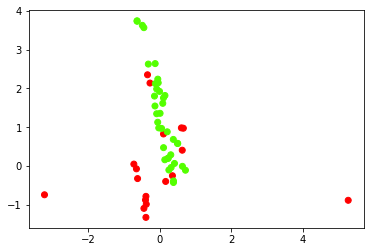

In [35]:
from functools import reduce
reference_frames = detections[:50]
arr_reference = np.array([ [d[1]] + list(d[2]) for d in reduce(lambda x, y: x+y, [d[1] for d in reference_frames])])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(arr_reference)
X_std = scaler.transform(arr_reference)

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
pca_matrix = sklearn_pca.fit(X_std)
Y_reference = pca_matrix.transform(X_std)

failed_frames = detections[50:150]
arr_detections = np.array([ [d[1]] + list(d[2]) for d in reduce(lambda x, y: x+y, [d[1] for d in failed_frames])])

X_std = scaler.transform(arr_detections)
Y_detection = pca_matrix.transform(X_std)

Y = np.vstack((Y_reference, Y_detection))
colors = np.hstack((np.repeat(0, Y_reference.shape[0]), np.repeat(1, Y_detection.shape[0])))
plt.scatter(Y[:,0], Y[:,1], c=colors, cmap=plt.cm.get_cmap('prism', 10))

In [36]:
def plot_detections(img, detection):
    for d in detection:
        score = '%.2f' % d[1]
        (xc, yc, w, h) = map(int, d[2])
        img = cv2.rectangle(img,(xc-w//2,yc-h//2),(xc+w//2,yc+w//2),(0,255,0),3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        img = cv2.putText(img,score,(xc-w//2,yc-h//2-10), font, 1,(255,0,0),3,cv2.LINE_AA)
    plt.imshow(img)

#### Here are all the frames in the initial 50 (used as reference frames) with positve detections.

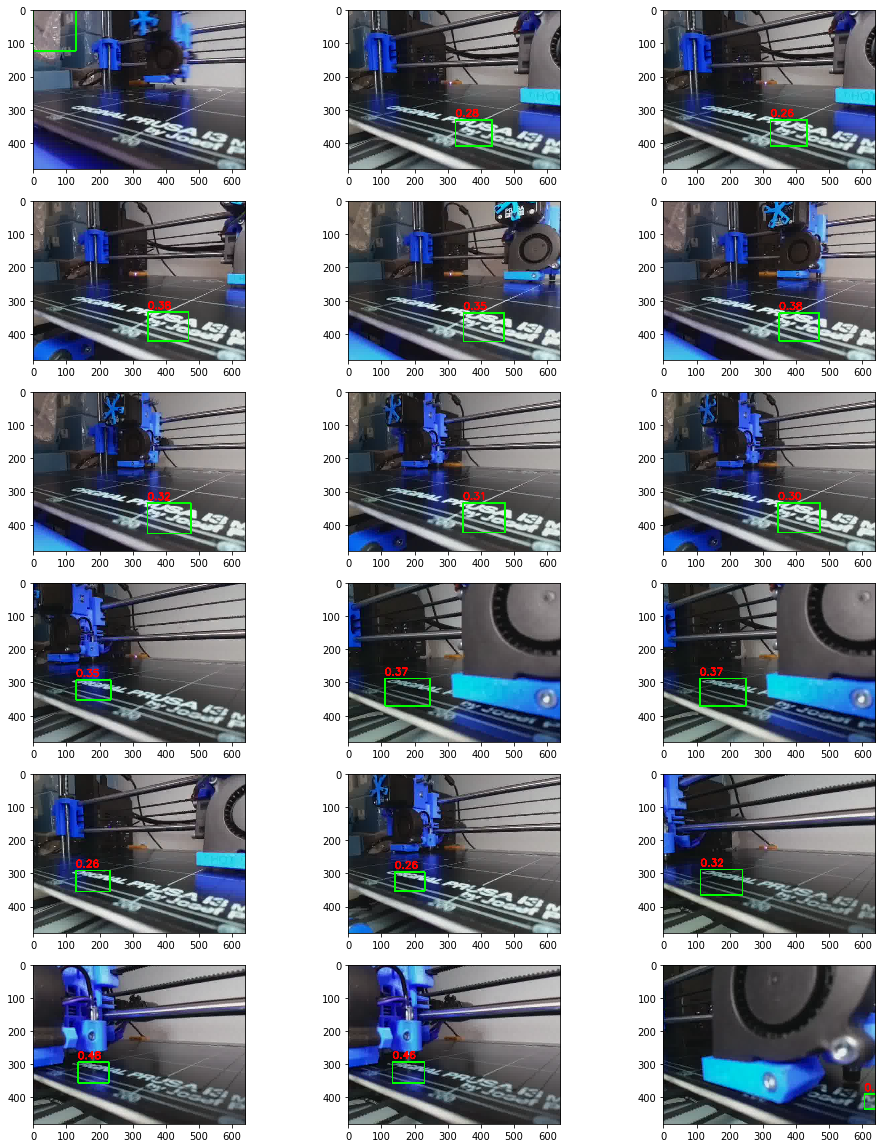

In [37]:
detected_frames = [d for d in detections[:50] if len(d[1]) > 0]

fig=plt.figure(figsize=(16, 16*len(detected_frames)/12))
    
for i, (img_file, d) in enumerate(detected_frames):
    img = cv2.imread(img_file)
    fig.add_subplot(len(detected_frames)/3+1, 3, i+1)
    plot_detections(img, d)
plt.show()


#### These are all the frames in the next 100 with positive detections

These detections seem very much the same as in the reference frames. But as the scatter plotted, they don't seem to cluster nearly as well as I expected

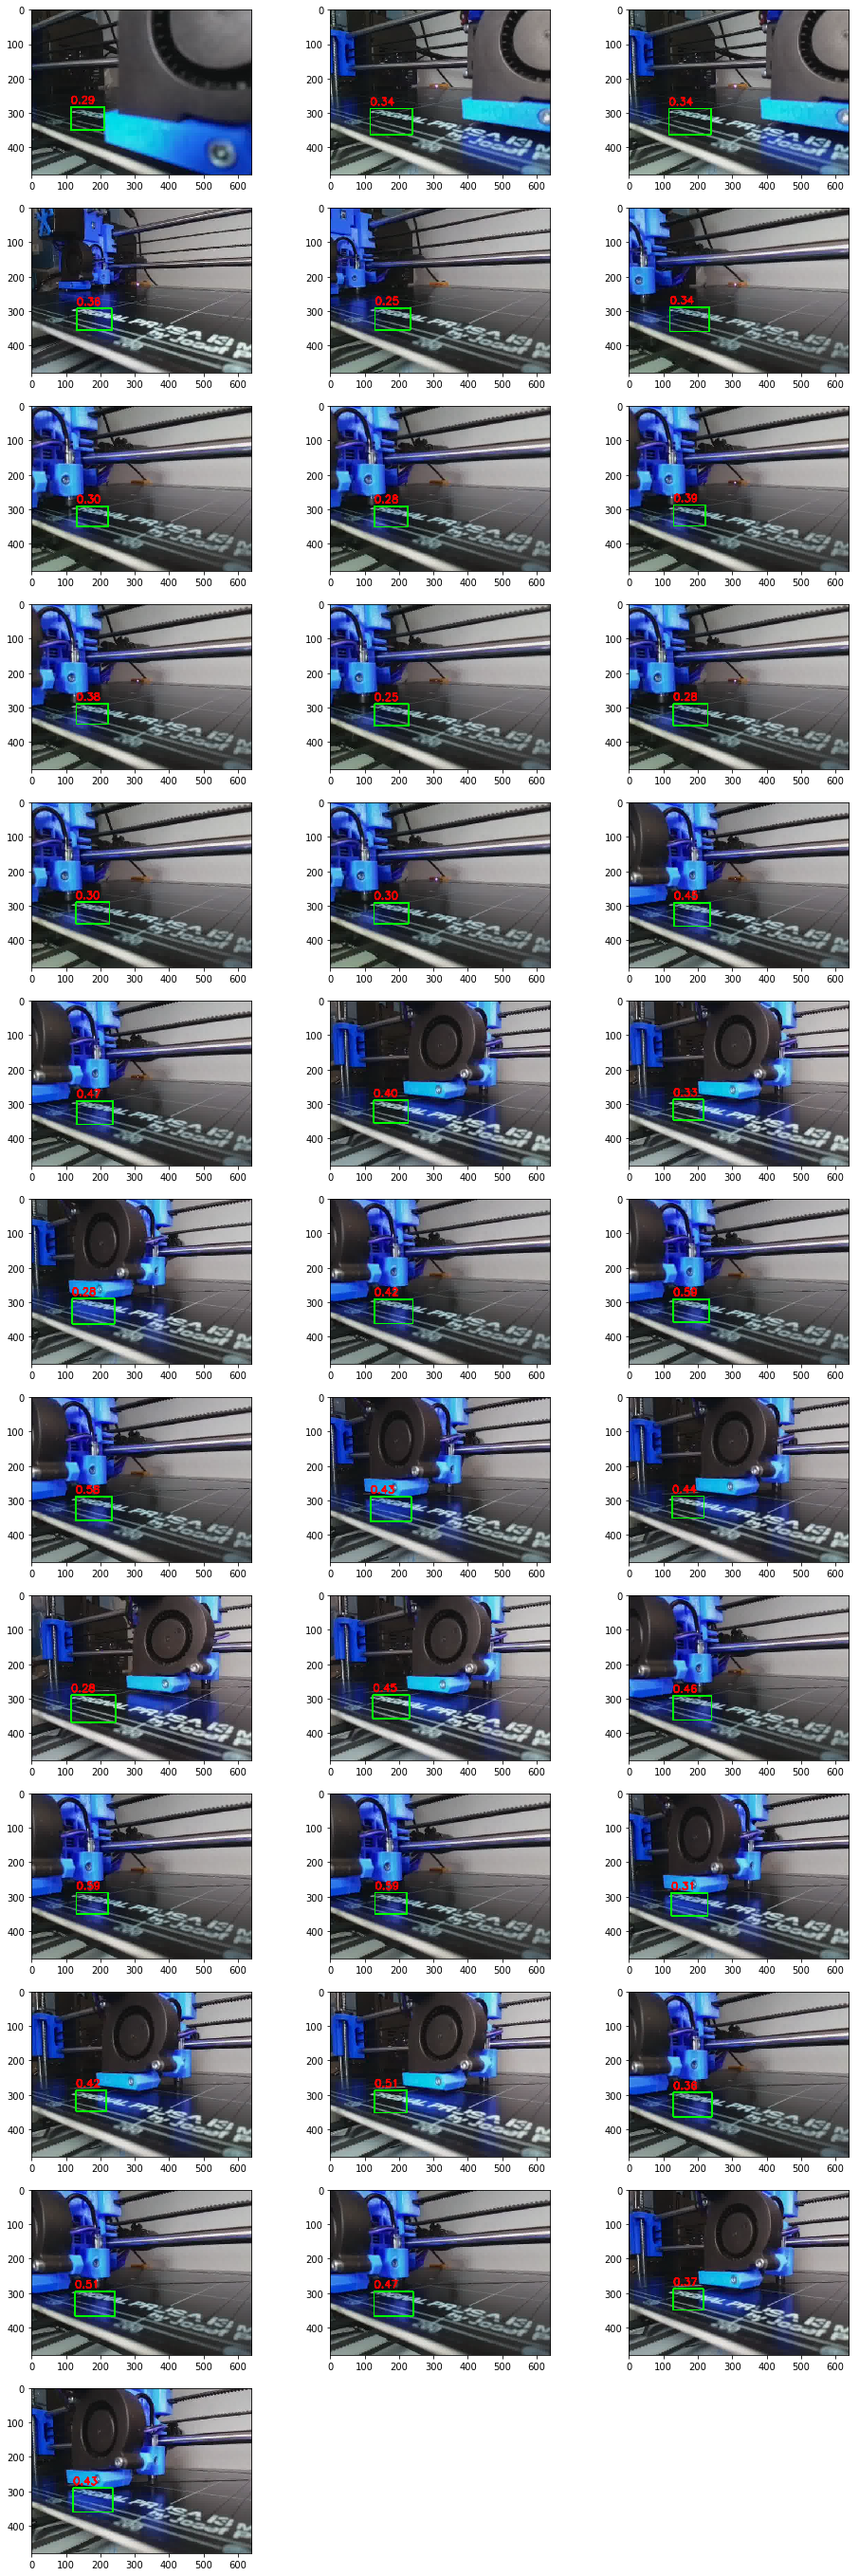

In [31]:
detected_frames = [d for d in detections[50:150] if len(d[1]) > 0]

fig=plt.figure(figsize=(16, 16*len(detected_frames)/12))
    
for i, (img_file, d) in enumerate(detected_frames):
    img = cv2.imread(img_file)
    fig.add_subplot(len(detected_frames)/3+1, 3, i+1)
    plot_detections(img, d)
plt.show()
